In [360]:
["a","b","c"] == ["ab","b","c"]

false

## <span style="color:orange">Recurrent Models with FluxML</span>

#### <span style="color:orange"> Flux does offer out of the box a set of recurrence functionalities in specific layers. Remember that recurrent models can come across as being more complicated than necessary. In general we are still dealing with the same type of funcational relationship, $\hat{y} = f(X_i) = f_{rnn}(X_t)$ where previously y_hat was either a single dimension or multiple dimensions, here $y_{hat} = [y_t , h_t]$ where $h_t$ is an input into the new time point (memory carry on) so that we have $X_t = [ x_t , h_{t-1}]$. The dependency can be seen as $\hat{y}_t = f(x_t,h_{t-1}), h_t = g(h_{t-1},x_t)$ </span>

- This basic recurrence relationship says that at each point we take the $h_{t-1}$ from the previous time step 't-1', we also use the current inputs at time t, $x_t$ and then produce an output which is has 2 components, $y_t$ and $h_t$ (where $h_t$ feeds into $t+1$). If we focus on a single time point, we are still doing the functional mapping that we had before with the chain of Dense layers.

- The below image [link source](https://www.google.com/url?sa=i&url=https%3A%2F%2Fmedium.com%2Fswlh%2Fintroduction-to-recurrent-neural-networks-rnns-347903dd8d81&psig=AOvVaw3xmMdMdDizNUUWXy021QUO&ust=1673451409556000&source=images&cd=vfe&ved=0CBAQjhxqFwoTCOCStLiqvfwCFQAAAAAdAAAAABA_) shows how this looks in a model diagram for **seq-to-seq** (**many to many**)

![rnn](./rnn1.png)

- also The below image [link source](https://www.ibm.com/topics/recurrent-neural-networks) shows how this looks

![rnn](./rnn2.jpeg)

----------------

#### <span style="color:orange"> $W_h$ is the weight matrix (tranformation) on the 'hidden inputs' $h_{t-1}$ that come from the previous unit's 'hidden' output, $W_x$ is the weight matrix (transformation) upon the inputs at the current time $x_t$. $W_y$ is the transformation weight matrix applied to the 'current' hidden value produced from the cell that after a non-linear transformation (activation function) produces the output $\hat{y}_t$. Training involves learning the values of the weights/parameters for these matrices.</span>

### <span style="color:orange"> $h_t = tahn(b_h + W_h^t h_{t-1} + W_x^t x_t)$ </span>
### <span style="color:orange"> $\hat{y}_t = softmax(b_y + W_{y}^{t} h_t)$ </span>

RNN can bring to mind the Kalman Filter

In [21]:
import Pkg
Pkg.status("Flux")

Status `~/.julia/environments/v1.8/Project.toml`
  [587475ba] Flux v0.13.11


In [1]:
using Flux
using Zygote
using Plots
using Distributions

In [58]:
#example of usage of the RNN unit
h_dim = 5 #hidden dimension
x_dim = 2 #input dimension at time t
y_dim = 1 #the output dimension that 'we' see

rnn_tmp = RNN( x_dim , h_dim ) #produces the cell
x_t1 = Float32.( [1,2] ) #some arbitrary input data
println( rnn_tmp( x_t1 ) ) #print the output h_t1 from the cell

Float32[-0.42449322, -0.780341, 0.8858426, 0.3879123, 0.64506674]


### <span style="color:orange"> It is key to know that this cell is different from the Dense layers in that it maintains the state between executions since it is **stateful**. This means it holds the state via a closure inside the function reference</span>

In [59]:
x_t1 = Float32.( [1,2] ) #some arbitrary input data
println( rnn_tmp( x_t1 ) ) #print the output h_t1 from the cell
#print multiple times to see the changes
display( [ rnn_tmp( x_t1 ) for _ in 1:4 ] )

Float32[-0.88633436, -0.9421285, 0.93829435, -0.2912246, -0.7543197]


4-element Vector{Vector{Float32}}:
 [-0.94388855, -0.88409203, 0.7260095, 0.33946013, -0.37083846]
 [-0.94723046, -0.8331355, 0.7455543, -0.013459079, -0.5831472]
 [-0.9384129, -0.82715374, 0.7115134, 0.18569449, -0.39269543]
 [-0.9388833, -0.8252977, 0.74333215, 0.047026403, -0.50348234]

### <span style="color:orange"> Since the RNN unit maintains and handles the state between subsequent uses we can abstractly use it in the ML pipeline as we used the Dense layer. From above notice that we produced hidden representation responses from inputs, but not the predictions $\hat{y}$ since those are done separately. </span>

### <span style="color:orange"> The RNN function implements $h_t = tahn(b_h + W_h^t h_{t-1} + W_x^t x_t)$ but $\hat{y}_t = softmax(b_y + W_{y}^{t} h_t)$ is not. The $W_{y}$ matrix is not provided by the RNN layer and must be supplied by the user. </span>

In [94]:
#we feed the model with 'x_dim' data, it produces a hidden vector 'h_dim' and outputs a 'y_dim' vector at each time
rnn_model1 = Chain( RNN( x_dim => h_dim ) , Dense( h_dim => y_dim , relu ), softmax ) 

Chain(
  Recur(
    RNNCell(2 => 5, tanh),              # 45 parameters
  ),
  Dense(5 => 1, relu),                  # 6 parameters
  NNlib.softmax,
)         # Total: 6 trainable arrays, 51 parameters,
          # plus 1 non-trainable, 5 parameters, summarysize 580 bytes.

In [95]:
#try out the model
rnn_model1( x_t1 )

1-element Vector{Float32}:
 1.0

In [96]:
[ rnn_model1( x_t1 ) for _ in 1:4 ]

4-element Vector{Vector{Float32}}:
 [1.0]
 [1.0]
 [1.0]
 [1.0]

In [97]:
#test the model with hypothetical data
x_length = 5
#generate some random data as inputs, to be treated as a sequence
x_seq = [ rand( Float32 , x_dim ) for i = 1:x_length ] #sequence data
[ rnn_model1( xt ) for xt in x_seq ] #predicted y_t data from the RNN
#this is <sequence to sequence> <many to many>

5-element Vector{Vector{Float32}}:
 [1.0]
 [1.0]
 [1.0]
 [1.0]
 [1.0]

### Let us look at how we can use batches, where a batch is a set of independent sentences in a single datastructure

In [99]:
batch_num = 4
x_seq = [ rand( Float32 , x_dim , batch_num ) for i = 1:x_length ]
display( size( x_seq[1] ) )
y_seq = [ rand( Float32 , y_dim , batch_num ) for i = 1:x_length ]
display( size( y[1] ) )

function loss1(x, y)
    Flux.reset!(m)
    println( "x " , [ size(xi) for (xi,yi) in zip(x,y) ] )
    println( "y " , [ size(yi) for (xi,yi) in zip(x,y) ] )
    #the way Julia does broadcasting means that we don't need to reset between batches
    return sum( [ Flux.mse(rnn_model1(x_b),y_b) for (x_b,y_b) in zip(x,y) ] )
end
println( "loss1 ",loss1(x_seq,y_seq) )

function loss2(x, y)
    Flux.reset!(m)
    loss = 0
    for (x_b,y_b) in zip(x,y)
        loss += Flux.mse(rnn_model1(x_b),y_b)
    end
    return loss
end
println( "loss2 ",loss2(x_seq,y_seq) )

(2, 4)

(1, 4)

x [(2, 4), (2, 4), (2, 4), (2, 4), (2, 4)]
y [(1, 4), (1, 4), (1, 4), (1, 4), (1, 4)]
loss1 1.9478507
loss2 1.9478507


### <span style="color:orange"> If you need to use the RNN and not have it dependent upon the previous state (eg. independent sentences), then you can use the **Flux.reset!(rnn_model)** command so the previous history variables are removed </span>

In [245]:
#start a new model fresh again
x_categories = [ "happy" , "sad" ]
y_categories = [ "steak" , "chicken" , "soup" ]
h_dim = 4 #hidden dimension
x_dim = length( x_categories ) #input dimension at time t
y_dim = length( y_categories ) #the output dimension that 'we' see
sequence_length = 8
p_emotions = [0.7,0.3] #higher prob of happy

rnn_model2 = Chain( RNN( x_dim => h_dim ) , Dense( h_dim => y_dim,relu), softmax )

Chain(
  Recur(
    RNNCell(2 => 4, tanh),              # 32 parameters
  ),
  Dense(4 => 3, relu),                  # 15 parameters
  NNlib.softmax,
)         # Total: 6 trainable arrays, 47 parameters,
          # plus 1 non-trainable, 4 parameters, summarysize 564 bytes.

In [246]:
#no updating via reset which resets the RNN hidden state
x_tmp = rand( Float32 , x_dim )
Flux.reset!(rnn_model2)
println( rnn_model2(x_tmp) )
Flux.reset!(rnn_model2)
println( rnn_model2(x_tmp) )
Flux.reset!(rnn_model2)
println( rnn_model2(x_tmp) )
Flux.reset!(rnn_model2)
println( rnn_model2(x_tmp) )
#updating
display( "----updating (no reset)----" )
println( rnn_model2(x_tmp) )
println( rnn_model2(x_tmp) )
println( rnn_model2(x_tmp) )
println( rnn_model2(x_tmp) )

Float32[0.24384971, 0.25276613, 0.5033842]
Float32[0.24384971, 0.25276613, 0.5033842]
Float32[0.24384971, 0.25276613, 0.5033842]
Float32[0.24384971, 0.25276613, 0.5033842]


"----updating (no reset)----"

Float32[0.27093616, 0.33859953, 0.39046434]
Float32[0.19206516, 0.33313408, 0.47480083]
Float32[0.26000652, 0.30973226, 0.43026122]
Float32[0.20215811, 0.31854793, 0.47929397]


#### (make some data on food choices) dependency is that when happy is seen: steak, then on subsequent happy: chicken, upon sad: soup (constantly)

the key is here that there should be memory of having seen sad which overrides newer observations of happy so that the menu serves soup regardless and that the RNN stores this information

In [247]:
function RNN_X_Data_Food( sequence_length )
    #rand(x_categories,sequence_length)
    return x_categories[ rand(Categorical(p_emotions),sequence_length) ] 
end
x_seq_cold = RNN_X_Data_Food( sequence_length )
println( x_seq_cold )
#dependency is that when happy is seen: steak, then on subsequent happy: chicken, upon sad: soup (constantly)
function RNN_Y_Data_Food( x_seq_cold )
    y_seq_cold = []
    prev_xx = ""
    #seen_sad = false
    for xx in x_seq_cold
        if( xx == "happy" && prev_xx != "happy" ) #seen_sad == false
            push!( y_seq_cold , "steak" )
        elseif( xx == "happy" )# && seen_sad == false && prev_xx == "happy" )
            push!( y_seq_cold , "chicken" )
        else
            push!( y_seq_cold , "soup" )
            #seen_sad = true
        end
        prev_xx = xx
    end
    return y_seq_cold
end
println( RNN_Y_Data_Food(x_seq_cold) ) #output food agenda
println("-------------")
x_seq_cold = RNN_X_Data_Food( sequence_length )
println( x_seq_cold )
println( RNN_Y_Data_Food(x_seq_cold) ) #output food agenda

["happy", "happy", "happy", "sad", "happy", "happy", "happy", "sad"]
Any["steak", "chicken", "chicken", "soup", "steak", "chicken", "chicken", "soup"]
-------------
["happy", "happy", "happy", "happy", "sad", "happy", "happy", "happy"]
Any["steak", "chicken", "chicken", "chicken", "soup", "steak", "chicken", "chicken"]


In [248]:
NN = 500
#generate the stochastic data upon the rule set defined in the functions
x_train_cold = [ RNN_X_Data_Food(sequence_length) for _ in 1:NN ]
display( x_train_cold[1:3] )
y_train_cold = RNN_Y_Data_Food.(x_train_cold)
display( y_train_cold[1:3] )
x_test_cold = [ RNN_X_Data_Food(sequence_length) for _ in 1:NN ]
y_test_cold = RNN_Y_Data_Food.(x_test_cold);

3-element Vector{Vector{String}}:
 ["sad", "happy", "sad", "happy", "happy", "sad", "happy", "happy"]
 ["happy", "happy", "sad", "happy", "happy", "happy", "happy", "happy"]
 ["sad", "happy", "sad", "happy", "happy", "sad", "happy", "happy"]

3-element Vector{Vector{Any}}:
 ["soup", "steak", "soup", "steak", "chicken", "soup", "steak", "chicken"]
 ["steak", "chicken", "soup", "steak", "chicken", "chicken", "chicken", "chicken"]
 ["soup", "steak", "soup", "steak", "chicken", "soup", "steak", "chicken"]

In [250]:
#put the label data into one-hot-batch
x_train = [ Flux.onehotbatch( x_train_cold[ii] , x_categories ) for ii in 1:length(x_train_cold) ]
display( x_train[1:4] )
display( x_train[1] )
x_test = [ Flux.onehotbatch( x_test_cold[ii] , x_categories ) for ii in 1:length(x_test_cold) ];
y_train = [ Flux.onehotbatch( y_train_cold[ii] , y_categories ) for ii in 1:length(y_train_cold) ];
display( y_train[1:4] )
display( y_train[1] )
y_test = [ Flux.onehotbatch( y_test_cold[ii] , y_categories ) for ii in 1:length(y_test_cold) ];

4-element Vector{OneHotArrays.OneHotMatrix{UInt32, 2, Vector{UInt32}}}:
 [0 1 … 1 1; 1 0 … 0 0]
 [1 1 … 1 1; 0 0 … 0 0]
 [0 1 … 1 1; 1 0 … 0 0]
 [1 1 … 0 1; 0 0 … 1 0]

2×8 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  ⋅  1  1  ⋅  1  1
 1  ⋅  1  ⋅  ⋅  1  ⋅  ⋅

4-element Vector{OneHotArrays.OneHotMatrix{UInt32, 3, Vector{UInt32}}}:
 [0 1 … 1 0; 0 0 … 0 1; 1 0 … 0 0]
 [1 0 … 0 0; 0 1 … 1 1; 0 0 … 0 0]
 [0 1 … 1 0; 0 0 … 0 1; 1 0 … 0 0]
 [1 0 … 0 1; 0 1 … 0 0; 0 0 … 1 0]

3×8 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  ⋅  1  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1
 1  ⋅  1  ⋅  ⋅  1  ⋅  ⋅

In [239]:
println( x_train_cold[1] ) #labels input
println( y_train_cold[1] ) #food output
println( x_train[1] ) #in numerical 1hot
println( y_train[1] ) #in numerical 1hot

y_hat = rnn_model2( x_train[1] ) #inspect what the model predicts given some training data (not trained yet)
println( y_hat ) #raw prediction vectors
println( Flux.onecold( y_hat , y_categories ) ) #the predicted 
Flux.mse( y_hat , y_train[1] ) #the error

["happy", "sad", "happy", "happy", "happy", "happy", "sad", "happy"]
Any["steak", "soup", "steak", "chicken", "chicken", "chicken", "soup", "steak"]
Bool[1 0 1 1 1 1 0 1; 0 1 0 0 0 0 1 0]
Bool[1 0 1 0 0 0 0 1; 0 0 0 1 1 1 0 0; 0 1 0 0 0 0 1 0]
Float32[0.5128329 0.3986957 0.5128329 0.5128329 0.5128329 0.5128329 0.3986957 0.5128329; 0.24358359 0.30065215 0.24358359 0.24358359 0.24358359 0.24358359 0.30065215 0.24358359; 0.24358359 0.30065215 0.24358359 0.24358359 0.24358359 0.24358359 0.30065215 0.24358359]
["steak", "steak", "steak", "steak", "steak", "steak", "steak", "steak"]


0.21784823f0

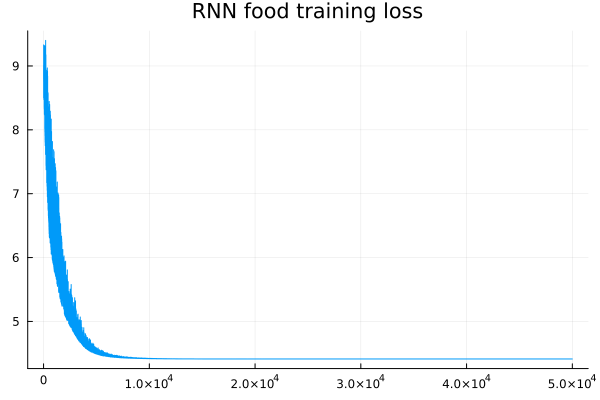

In [368]:
rnn_model2 = Chain( RNN(2=>4),Dense(4=>3,sigmoid),softmax)
data = Flux.DataLoader( (x_train, y_train) , batchsize=1 , shuffle=true )
opt = Flux.setup( Flux.Adam(0.001) , rnn_model2 )

losses = []
for epoch in 1:100
    for ( x , y ) in data
        
        x_us = Flux.unstack(Float32.(x[1]),dims=2)
        y_us = Flux.unstack(Float32.(y[1]),dims=2)

        Flux.reset!(rnn_model2) #important or else the model takes the 'hidden' values from previous usage 
        
        loss_tmp, grads = Flux.withgradient( rnn_model2 ) do model                        
            loss = 0
            for ii in 1:length(x_us)
               
                    y_hat = model( x_us[ii] )
                    loss += Flux.crossentropy( y_hat , y_us[ii] )
                
            end
            return loss
        end     
        Flux.update!( opt , rnn_model2 , grads[1] )
        push!(losses,loss_tmp) #don't put this in the above block where the gradient is computed
    end
    
end
p1 = plot( losses , title="RNN food training loss" , legend=false )
savefig(p1,"p1.png")
display(p1)

In [369]:
data = Flux.DataLoader( (x_test, y_test) , batchsize=1 , shuffle=true )
jj = 0
correct_pred = []
for ( x , y ) in data
    
    true_meals = Flux.onecold( y[1] , y_categories )
    x_us = Flux.unstack( Float32.(x[1]) , dims=2 )
    y_us = Flux.unstack( Float32.(y[1]) , dims=2 )
    Flux.reset!( rnn_model2 )
    y_hat = []
    for ii in 1:length(x_us)               
        meal = Flux.onecold( rnn_model2(x_us[ii]) , y_categories )
        push!( y_hat , meal )
    end
    
    push!( correct_pred , true_meals == y_hat )
    
    if(jj<12)
        println("       y: " , true_meals )
        println( "y_hat: " , y_hat )
        jj += 1
    end
end
println("----------------------------------------")
println( "accuracy of meal predictions = " , 100 * sum(correct_pred)/length(correct_pred) , "%")

       y: ["soup", "steak", "chicken", "soup", "steak", "chicken", "chicken", "soup"]
y_hat: Any["soup", "steak", "chicken", "soup", "steak", "chicken", "chicken", "soup"]
       y: ["steak", "chicken", "chicken", "soup", "soup", "steak", "chicken", "chicken"]
y_hat: Any["steak", "chicken", "chicken", "soup", "soup", "steak", "chicken", "chicken"]
       y: ["soup", "steak", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken"]
y_hat: Any["soup", "steak", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken"]
       y: ["soup", "steak", "soup", "steak", "chicken", "chicken", "soup", "steak"]
y_hat: Any["soup", "steak", "soup", "steak", "chicken", "chicken", "soup", "steak"]
       y: ["steak", "chicken", "soup", "steak", "soup", "steak", "chicken", "soup"]
y_hat: Any["steak", "chicken", "soup", "steak", "soup", "steak", "chicken", "soup"]
       y: ["soup", "steak", "chicken", "chicken", "chicken", "chicken", "chicken", "chicken"]
y_hat: Any["soup", "steak", "chi

[link source](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.codeproject.com%2FArticles%2F3993967%2FApplying-Long-Short-Term-Memory-for-Video-Classifi&psig=AOvVaw3aJjMa8pFFZ1i53Lk2C-gE&ust=1673466988547000&source=images&cd=vfe&ved=0CBAQjhxqFwoTCNjijr7kvfwCFQAAAAAdAAAAABA4)

![rnn](./rnnTypes.jpg)

#### Let's consider the <u>**sequence to one**</u> (seq-to-one) now

#### Many-to-One Sequence Problems. In many-to-one sequence problems, we have a sequence of data as input, and we have to predict a single output. Sentiment analysis or text classification is one such use case.


In [9]:

#loss function for 3-to-1, a sequence of 3 inputs for a single output
#this can be used in the training scheme as before
function loss_3_to_1( x , y ) #assume feature data has 3 samples
    rnn_model1( x[1] ) # ignores the output but updates the hidden states
    rnn_model1( x[2] ) # ignores the output but updates the hidden states again
    y_hat = rnn_model1( x[3] )
    println( y_hat )
    Flux.mse( y_hat , y )
end

y = rand( Float32 , y_dim ) #target data
x = [ rand(Float32, x_dim ) for i=1:3 ] #sequence of 3 x values
println("y=",y," x=",x)
loss_3_to_1( x , y )

y=Float32[0.24803472] x=Vector{Float32}[[0.7601079, 0.84414154], [0.84445024, 0.28849977], [0.449445, 0.9851977]]
Float32[1.4257019]


1.3869f0

In [10]:
#produce a hypothetical sequence of data points in x_dim dimensions
#with y_dim data and pass that to the loss
x_data = [ [rand(Float32,x_dim) for i=1:3] for j=1:10 ]
y_data = [ rand( Float32 , y_dim ) for j=1:10 ]
data = zip( x_data , y_data ) #pack the data into pairs

for (x_tmp,y_tmp) in data
    println( "loss = " , loss_3_to_1( x_tmp , y_tmp ) )
end

Float32[1.9506261]
loss = 1.1709299
Float32[1.5288637]
loss = 0.28548747
Float32[1.3258337]
loss = 1.6201891
Float32[1.6926062]
loss = 2.0465567
Float32[1.7179067]
loss = 0.5677387
Float32[0.9220013]
loss = 0.3709042
Float32[1.5273948]
loss = 1.9376503
Float32[1.3230592]
loss = 0.8318744
Float32[1.7548747]
loss = 0.6737301
Float32[1.2160401]
loss = 0.16275056


In [11]:
#add a reset so that each sentence is taken independently
function loss_3_to_1_reset( x , y ) #assume feature data has 3 samples
    Flux.reset!( rnn_model1 ) #reset the model from previous sentences
    rnn_model1( x[1] ) # ignores the output but updates the hidden states
    rnn_model1( x[2] ) # ignores the output but updates the hidden states again
    y_hat = rnn_model1( x[3] )
    Flux.mse( y_hat , y )
end

loss_3_to_1_reset (generic function with 1 method)

### <span style="color:orange">One to many RNN</span>

- Take a single X input and then output a series of Y outputs
- Some architectures will require a bit of manual construction
- One-to-many sequence problems are sequence problems where the input data has one time-step, and the output contains a vector of multiple values or multiple time-steps. Thus, we have a single input and a sequence of outputs.
A typical example is image captioning, where the description of an image is generated. Or music generation from a description.

[link source](https://www.google.com/url?sa=i&url=https%3A%2F%2Fdiscuss.pytorch.org%2Ft%2Fone-to-many-lstm%2F96932&psig=AOvVaw0Ha6GO6T8UyXiD-It1widc&ust=1673625753189000&source=images&cd=vfe&ved=0CBAQjhxqFwoTCMie7vWzwvwCFQAAAAAdAAAAABBa)

![rnn](./rnn1toMany.jpeg)

[link source](https://www.google.com/url?sa=i&url=https%3A%2F%2Fdiscuss.pytorch.org%2Ft%2Fone-to-many-lstm%2F96932&psig=AOvVaw0Ha6GO6T8UyXiD-It1widc&ust=1673625753189000&source=images&cd=vfe&ved=0CBAQjhxqFwoTCMie7vWzwvwCFQAAAAAdAAAAABBa)

![rnn](./one-to-many.png)

### In this case we must make sure the 'hidden' state values are cycled as inputs and the previous unit definitions abstract away that hidden unit productions. The units must return the states (hidden) so be passed as subsequent inputs.

#### instead of having Flux handle the internal state (h) we can maintain it explicitly

In [12]:
#create a RNN cell which does not handle internal state automatically
#which means that we have to retrieve the 'h' state value and pass it back in to the next step
x_dim = 2
h_dim = 2
h_init = rand( Float32 , h_dim )
x_init = rand( Float32 , x_dim )

rnn1 = Flux.RNNCell( x_dim, h_dim, sigmoid ) #define x_dim and then h_dim

h , y = rnn1( h_init , x_init ) #pass h and then x to get the h and y outputs

(Float32[0.23961921, 0.5914116], Float32[0.23961921, 0.5914116])

In [18]:
#Now we pass the outputs 'y' from the rnn units as 'x' data in subsequent steps
x_dim = 2
h_dim = 2
h_init = rand( Float32 , h_dim )
x_init = rand( Float32 , x_dim )

rnn1 = Flux.RNNCell( x_dim, h_dim, sigmoid ) #define x_dim and then h_dim
m1 = Flux.Dense( 2 => 1 , sigmoid )

h , y = rnn1( h_init , x_init ) #pass h and then x to get the h and y outputs

h , y = rnn1( h , y ) #pass h and then x to get the h and y outputs
h , y = rnn1( h , y ) #pass h and then x to get the h and y outputs
h , y = rnn1( h , y ) #pass h and then x to get the h and y outputs
y_hat = m1( y )

1-element Vector{Float32}:
 0.6980755

In [17]:
nsteps = 4
xs = [rand(Float32, 3, 2) for i in 1:nsteps]
display( xs )
m = Chain(RNN(3, 5))
[ display(m(x)) for x = xs] 

4-element Vector{Matrix{Float32}}:
 [0.7193387 0.33868003; 0.016090214 0.256925; 0.2488938 0.47927523]
 [0.56273735 0.5567441; 0.20874453 0.45442927; 0.6528861 0.7265376]
 [0.5801285 0.41532242; 0.91156983 0.92337066; 0.66897005 0.5273158]
 [0.73792315 0.7799565; 0.5407746 0.5092; 0.6379438 0.23041004]

5×2 Matrix{Float32}:
 -0.344579  -0.125573
 -0.119549  -0.341085
  0.22776    0.012745
 -0.451451  -0.568937
  0.337278  -0.00986344

5×2 Matrix{Float32}:
  0.138712    0.112828
 -0.326718   -0.57339
 -0.0753149  -0.490038
 -0.862643   -0.845221
  0.167302    0.156598

5×2 Matrix{Float32}:
  0.477808   0.602143
 -0.618007  -0.544691
 -0.528367  -0.617153
 -0.925458  -0.913587
  0.371714   0.403402

5×2 Matrix{Float32}:
  0.738152   0.738869
 -0.659737  -0.444979
 -0.471581  -0.31129
 -0.907443  -0.83823
  0.788016   0.860447

4-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing

In [14]:
### <span style="color:orange">write a function and make a function for the gradient of the function</span>